In [10]:
import beaker
import datetime
import matplotlib.pyplot as plt
import cftime
import xarray as xr
plt.rcParams['figure.dpi'] = 150

In [3]:
beaker_experiment_id = '01JAP8STG63MEMNA2R8G1AF6YP'

In [4]:
client = beaker.Beaker.from_env()

/home/OliWM/miniconda3/envs/ace2-paper/lib/python3.10/site-packages/beaker/util.py:25: RuntimeWarning: Found unknown field 'environments: 0' for data model 'WorkspaceSize'. This may be a newly added field that hasn't been defined in beaker-py yet. Please submit an issue report about this here:
https://github.com/allenai/beaker-py/issues/new?assignees=&labels=bug&template=bug_report.yml
  warnings.warn(
/home/OliWM/miniconda3/envs/ace2-paper/lib/python3.10/site-packages/beaker/client.py:163: UserWarning: You're using beaker-py v1.31.3, but a newer version (v1.32.0) is available.

Please upgrade with `pip install --upgrade beaker-py`.

You can find the release notes for v1.32.0 at https://github.com/allenai/beaker-py/releases/tag/v1.32.0

  warnings.warn(


In [6]:
dates = []
strengths = []

for page in client.experiment.logs(beaker_experiment_id, quiet=True):
    page_str = page.decode('utf-8')
    lines = page_str.split('\n')
    for line in lines:
        if 'Time: [cftime.DatetimeProlepticGregorian' in line and "device='cuda:0')" in line:
            #print(line)
            start, end = line.split('], SH vortex strength: ')[:2]
            _, date_str = start.split('Time: [')
            end2 = end.split(']')[0]
            strength = end2.split('[')[1]
            dates.append(eval(date_str))
            strengths.append(float(strength))

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 1022-1023: unexpected end of data

In [11]:
da = xr.DataArray(strengths, dims='time', coords={'time': dates})

In [12]:
da

<xarray.DataArray (time: 1006823)> Size: 8MB
array([34.5089, 34.009 , 32.811 , ..., 39.1877, 39.3871, 39.5612])
Coordinates:
  * time     (time) object 8MB 2200-11-14 06:00:00 ... 3000-05-03 18:00:00

In [13]:
start_year = 2201
end_year = 2999
#end_year = 2210
by_day_of_year = []
for year in range(start_year, end_year + 1):
    current_year = da.sel(time=str(year)).groupby('time.dayofyear').mean('time')
    current_year = current_year.isel(dayofyear=slice(0, 365))  # drop leap day
    current_year = current_year.assign_coords(year=year)
    by_day_of_year.append(current_year)
by_day_of_year = xr.concat(by_day_of_year, dim='year')

Text(0.5, 1.0, '800 years of ACE2-ERA5 forced by climSST')

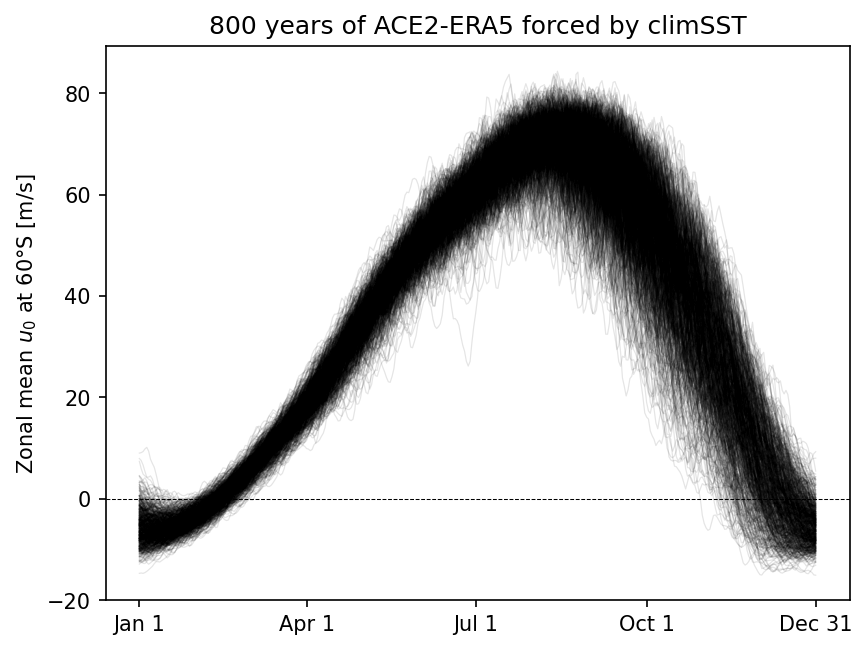

In [14]:
fig, ax = plt.subplots()
ax.hlines(0, 0, 1, transform=ax.get_yaxis_transform(), color='k', linestyle='--', linewidth=0.5)
for year in range(start_year, end_year + 1):
    by_day_of_year.sel(year=year).plot(ax=ax, color='black', alpha=0.1, linewidth=0.6)
ticks = [datetime.datetime(2001, month, 1) for month in [1, 4, 7, 10]] + [datetime.datetime(2001, 12, 31)]
tick_labels = [t.strftime('%b %-d') for t in ticks]
tick_day_of_year = [t.timetuple().tm_yday for t in ticks]
ax.set_xticks(tick_day_of_year)
ax.set_xticklabels(tick_labels)
ax.set_xlabel('')
ax.set_ylabel('Zonal mean $u_0$ at 60°S [m/s]')
ax.set_title('800 years of ACE2-ERA5 forced by climSST')